# Emergency Response Shortest Path

**Project for *Selected Topics for Mathematical Optimization***

Professor Paul Van Liederke

### Contributors:
- Jihwan Lim
- Yunseol Park

## Introduction

In [39]:
import pandas as pd
import random
import math
from math import inf
import haversine
import matplotlib.pyplot as plt
import matplotlib
import datetime
from numpy import inf
from heapq import heapify, heappop, heappush
from matplotlib.animation import FuncAnimation
from functools import partial

## Data
We generated a simulated city based off of real information from Seoul city, South Korea.

The city of Seoul is divided into smaller regions and the smallest administrative region is called *dong* (동), with each *dong* being around 0.2 to 12 $km^2$. There is 1 administrative office (주민센터) per *dong* and there are 426 of these in Seoul alone.

As mapping an entire city may be computationally challenging, we mapped these offices by their longitude and latitude to make the nodes of our graph. The data of this information was taken from the [Public Data Portal](https://www.data.go.kr/data/15059715/fileData.do).

In [40]:
def filter_data():
    '''
    Filters the data to have administrative office information

    Args:
        None
    Returns:
        loc_dict (dict): dictionary that has the dong name (ㅇㅇ구 ㅇㅇ동) as key and a tuple with the longitude and latitude as values
    '''
    # Read in data and only keep necessary columns
    city_df = pd.read_csv('data/전국공공시설개방정보표준데이터.csv', encoding='cp949')
    city_df = city_df[['관리기관명','개방시설명','개방장소명','위도','경도']]
    # Filter on Seoul city
    city_df = city_df[city_df['관리기관명'].str.contains('서울특별시')]
    # Some data are in the column 개방시설명 instead of 개방장소명
    ## Filter on 주민센터 then save the information in the column 개방장소명
    extra_df = city_df[city_df['개방시설명'].str.contains('주민센터')]
    extra_df = extra_df[~extra_df['개방장소명'].str.contains('주민센터')]
    extra_df['개방장소명'] = extra_df['개방시설명'].str.split('주민센터').str[0].str.strip()
    extra_df['개방장소명'] = extra_df['개방장소명'].str.split('구 ').str[-1]
    extra_df = extra_df.drop('개방시설명',axis=1).drop_duplicates()
    # The rest of the data are in the column 개방장소명 so drop 개방시설명
    city_df = city_df.drop(['개방시설명'], axis=1)
    city_df = city_df.dropna()      # Remove NA values
    ## Filter on 주민센터
    city_df = city_df[city_df['개방장소명'].str.contains('주민센터')]
    city_df['개방장소명'] = city_df['개방장소명'].str.split('주민센터').str[0].str.strip()
    city_df['개방장소명'] = city_df['개방장소명'].str.split('구 ').str[-1]
    # Concatinate the two dataframes together
    loc_df = pd.concat([city_df, extra_df])
    # Change the 관리기관명 column so that only the 구 name is in it
    loc_df['관리기관명'] = loc_df['관리기관명'].str.split().str[1]
    loc_df['관리기관명'] = loc_df['관리기관명'].str.replace('구청','구')
    # Remove duplicates
    loc_df = loc_df.drop_duplicates(subset=['관리기관명', '개방장소명'])
    # Make a new column that contains the columns 관리기관명 and 개방장소명
    loc_df['동'] = loc_df['관리기관명'] + ' ' + loc_df['개방장소명']
    # Convert the dataframe into dictionary with only the columns 동, 위도, 경도
    loc_dict = loc_df.set_index('동')[['경도', '위도']].apply(tuple, axis=1).to_dict()
    return loc_dict
loc_dict = filter_data()
loc_dict

{'노원구 중계4동': (127.077958, 37.658728),
 '노원구 상계1동': (127.054976, 37.679929843),
 '광진구 자양4동': (127.0662584, 37.53409779),
 '광진구 화양동': (127.0713179, 37.54653711),
 '광진구 군자동': (127.075486, 37.555495),
 '도봉구 쌍문2동': (127.0387508, 37.6580211),
 '도봉구 쌍문4동': (127.0283688, 37.6564188),
 '도봉구 쌍문3동': (127.0279086, 37.6489437),
 '도봉구 쌍문1동': (127.0260364, 37.6479992),
 '광진구 광장동': (127.1030098, 37.54688276),
 '광진구 자양1동': (127.0823949, 37.53449795),
 '광진구 자양2동': (127.0843875, 37.52879933),
 '광진구 자양3동': (127.0729024, 37.53383394),
 '광진구 중곡1동': (127.0800521, 37.56066762),
 '광진구 중곡2동': (127.0814751, 37.56015047),
 '광진구 중곡3동': (127.0801381, 37.56880689),
 '광진구 중곡4동': (127.0894329, 37.55909865),
 '광진구 능동': (127.0805521, 37.5537606),
 '광진구 구의1동': (127.0856773, 37.54241324),
 '광진구 구의2동': (127.0899239, 37.54724133),
 '광진구 구의3동': (127.0919847, 37.53799342),
 '도봉구 방학3동': (127.0279921, 37.6591413),
 '도봉구 방학1동': (127.0406367, 37.6641869),
 '도봉구 방학2동': (127.0350425, 37.668177),
 '도봉구 창1동': (127.0440451, 37.6485286

## Simulated city

From the data gathered, we randomly pick 10 as towns or households where the emergency events take place. We also pick some as hospitals or emergency rooms h(ERs). To do so, we make use of the actual ratio between ERs and administrative offices that are in Seoul. Then we also pick some as the emergency responders. Here, we take a third of the number of hospitals. Since the emergency events are set to be always medical in this project, and not other events, we require less responders than there are in reality.

In [41]:
# Get random example
random.seed(100)
keys_list = list(loc_dict.keys())
# List of random names to use for towns
towns = random.sample(keys_list, 50)
keys_list = [i for i in keys_list if i not in towns]
# List of random names to use as hospitals
#ratio = 67/426
ratio = 0.5
hospital = random.sample(keys_list, round(ratio*10))
keys_list = [i for i in keys_list if i not in hospital]
# List of random names to use as ambulance location / emergency services
ambulance = random.sample(keys_list, round(len(hospital)/3))
towns, hospital, ambulance

(['노원구 공릉1동',
  '서초구 방배2동',
  '서초구 방배1동',
  '강북구 수유2동',
  '강동구 둔촌2동',
  '관악구 청림동',
  '중랑구 묵1동',
  '성동구 사근동',
  '구로구 고척2동',
  '중랑구 신내1동',
  '강서구 등촌1동',
  '금천구 시흥5동',
  '성동구 응봉동',
  '중구 황학동',
  '노원구 하계1동',
  '광진구 구의3동',
  '성동구 성수1가제1동',
  '은평구 불광1동',
  '강서구 공항동',
  '광진구 자양3동',
  '강동구 강일동',
  '중구 소공동',
  '강동구 암사3동',
  '구로구 구로2동',
  '송파구 장지동',
  '구로구 오류1동',
  '강북구 수유1동',
  '영등포구 양평1동',
  '도봉구 창3동',
  '노원구 월계3동',
  '도봉구 도봉2동',
  '구로구 고척1동',
  '강서구 화곡1동',
  '강북구 삼양동',
  '중랑구 면목4동',
  '강동구 천호1동',
  '중랑구 면목5동',
  '서초구 방배3동',
  '중구 청구동',
  '동대문구 휘경1동',
  '서초구 양재1동',
  '강동구 성내2동',
  '중구 회현동',
  '중구 필동',
  '송파구 석촌동',
  '도봉구 창5동',
  '노원구 상계1동',
  '강북구 번1동',
  '중랑구 면목본동',
  '양천구 목5동'],
 ['서대문구 북가좌1동', '강동구 천호3동', '금천구 독산1동', '강서구 방화3동', '도봉구 쌍문3동'],
 ['영등포구 신길3동', '중랑구 망우3동'])

### Generate graph

From the example from above, we now generate the graphs connecting the nodes. The connections are made randomly, to a random number of nodes between 1 to 3 for the households. For ERs and responders, we make the maximum number of connections to 4 nodes. As for the actual connections, we connect nodes based on the distance (i.e. the closer two nodes are, the more likely they will be connected).

As our data is on longitude and latitude information, we make use of *haversine* distance calculation to calculate the acutal distance in *km*s between the two nodes and set these distances as the edges of the graph. We also change the names of the nodes since their original names are in Korean. The towns or households have the prefix **T**, hospital with **H**, and ambulance or emergency responder with **A**, and the postfix with numbers to them.

In [42]:
def make_paths(loc_dict, towns, hospital, ambulance):
    '''
    Function that connects the chosen nodes together.

    Args:
        loc_dict (dict): dictionary that has the dong name (ㅇㅇ구 ㅇㅇ동) as key and a tuple with the longitude and latitude as values
        towns (list): list of names of dong 
        hospital (list): list of names of hospitals 
        ambulance (list): list of names of emergency services
    Returns:
        connections (list): list of tuples that contain the haversine distance, and two names of nodes that are connected together
        graph_dict (dict): subset of 'loc_dict' that only contains the names given in 'towns' 'hospital' 'ambulance' lists
    '''
    # Make a dictionary with all the nodes with new names and their coordinates
    # Get a list with all the nodes
    city = towns + hospital + ambulance
    graph_dict = {}
    # Number to use as postfix for the name
    town_nodes = 0
    hospital_nodes = 0
    ambulance_nodes = 0
    for node in city:
        # Get lat and lon information of node
        x1, y1 = loc_dict[node]
        # Change name of nodes
        if node in towns:
            town_nodes += 1
            new_node = 'T{}'.format(town_nodes)
        elif node in hospital:
            hospital_nodes += 1
            new_node = 'H{}'.format(hospital_nodes)
        else:
            ambulance_nodes += 1
            new_node = 'A{}'.format(ambulance_nodes)
        graph_dict[new_node] = loc_dict[node]       # Save to graph_dict

    # Make edges for the graph
    connections = []    # List to save edges
    for node, (x1,y1) in graph_dict.items():
        # List to save distances to all other nodes
        distance = []
        # Get lat and lon information of node
        x1, y1 = graph_dict[node]
        # Choose how many other nodes it is connected to
        if node in towns:
            connect = random.randint(1,3)   # Random if it is a town
        # If it is in 'hospital' or 'ambulance' lists, then make the maximum connections
        else:
            connect = 4
        # If the node has already been connected to others, remove that number from 'connect'
        # Only keep the number of connections that needs to be made
        counted = [i[1] for i in connections if node == i[1]]
        connect -= len(counted)
        # Loop over all the nodes to connect with
        for test, (x2,y2) in graph_dict.items():
            if connect == 0:    # Break loop if no connection is needed
                break
            if node == test:    # No need to calculate the distance in one node
                continue
            # Calculate haversine distance between the two (km)
            dist = haversine.distance((x1,y1),(x2,y2))
            distance.append((test, dist))
        # Sort the distances to the nodes and take the top n nodes (n=connect)
        con_city = sorted(distance, key=lambda x:x[1])[:connect+1]
        connections += [(i[1], node, i[0]) for i in con_city]       # Save the top nodes
    return connections, graph_dict

edges, graph_dict = make_paths(loc_dict, towns, hospital, ambulance)
edges, graph_dict

([(0.9794882745330652, 'T1', 'T7'),
  (1.0652699803861423, 'T1', 'T15'),
  (1.2498894794090791, 'T1', 'T30'),
  (2.313823402048196, 'T1', 'T40'),
  (2.6918655258837023, 'T1', 'T37'),
  (1.024426647939939, 'T2', 'T3'),
  (1.6060680805966159, 'T2', 'T38'),
  (3.1016787600858513, 'T2', 'T6'),
  (4.603176230363664, 'T2', 'T41'),
  (5.2306759121164825, 'T2', 'T43'),
  (0.6918535090223883, 'T3', 'T38'),
  (1.024426647939939, 'T3', 'T2'),
  (3.660270975549514, 'T3', 'T41'),
  (4.0304326582453225, 'T3', 'T6'),
  (5.138918739000868, 'T3', 'T44'),
  (0.9384660247659319, 'T4', 'H5'),
  (1.0080800086008581, 'T4', 'T27'),
  (1.0952646199642928, 'T4', 'T48'),
  (1.3169061366646448, 'T4', 'T34'),
  (2.593644479740694, 'T4', 'T29'),
  (1.0053897521435444, 'T5', 'H2'),
  (1.4593853253141653, 'T5', 'T36'),
  (2.051386433019284, 'T5', 'T23'),
  (2.175782715342137, 'T5', 'T42'),
  (3.2863321258942846, 'T5', 'T25'),
  (3.1016787600858513, 'T6', 'T2'),
  (4.0304326582453225, 'T6', 'T3'),
  (4.68495631554274

In [43]:
# Change the town, hospital, ambulance lists with those with new names
towns = []
hospital = []
ambulance = []
for key in graph_dict.keys():
    if 'T' in key:
        towns.append(key)
    elif 'H' in key:
        hospital.append(key)
    else:
        ambulance.append(key)
towns, hospital, ambulance

(['T1',
  'T2',
  'T3',
  'T4',
  'T5',
  'T6',
  'T7',
  'T8',
  'T9',
  'T10',
  'T11',
  'T12',
  'T13',
  'T14',
  'T15',
  'T16',
  'T17',
  'T18',
  'T19',
  'T20',
  'T21',
  'T22',
  'T23',
  'T24',
  'T25',
  'T26',
  'T27',
  'T28',
  'T29',
  'T30',
  'T31',
  'T32',
  'T33',
  'T34',
  'T35',
  'T36',
  'T37',
  'T38',
  'T39',
  'T40',
  'T41',
  'T42',
  'T43',
  'T44',
  'T45',
  'T46',
  'T47',
  'T48',
  'T49',
  'T50'],
 ['H1', 'H2', 'H3', 'H4', 'H5'],
 ['A1', 'A2'])

The graph is then plotted with the emergency responders as red and hospital/ER as blue.

Text(0, 0.5, 'latitude')

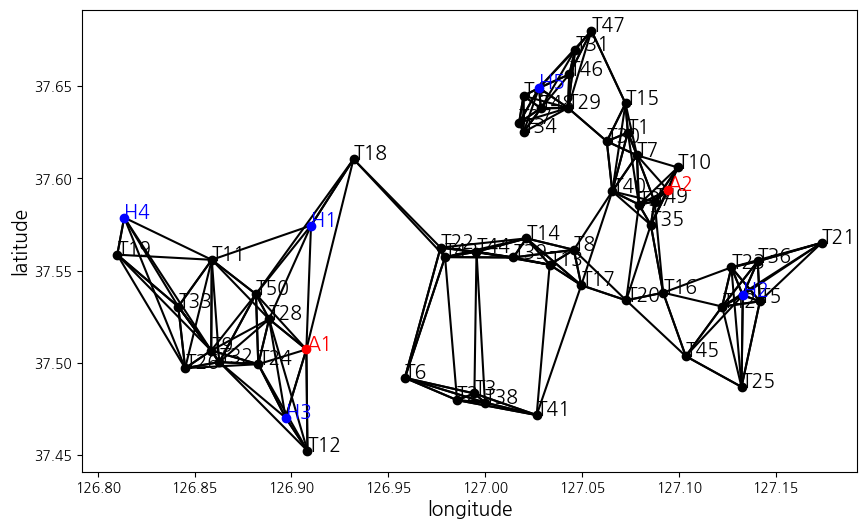

In [44]:
"""# Make a map of the graph
# Due to the names being KR, change font
path = "data/NanumGothic.ttf"
font_name = matplotlib.font_manager.FontProperties(fname=path).get_name()
plt.rcParams.update({'font.family':font_name})"""

fig, ax = plt.subplots(figsize=(10, 6))
# Plot the nodes
for city, (lon, lat) in graph_dict.items():
    # Use different colors for different types of nodes
    if city in hospital:
        ax.scatter(lon, lat, color="blue", zorder=4)
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="blue")
    elif city in ambulance:
        ax.scatter(lon, lat, color="red", zorder=4)
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="red")
    else:
        ax.scatter(lon, lat, color="black", zorder=3)
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="black")

# Plot the edges
for w, c1, c2 in edges:
    x1, y1 = graph_dict[c1]
    x2, y2 = graph_dict[c2]
    plt.plot([x1,x2],[y1,y2], color='black', zorder=1)

ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)

The distances that we calculated above for the edges are now converted into travel times, and we also add traffic times as well. For the travel time, we assume the ambulance travels at the speed of 70 km/h as the speed limit of the city is usually 50 km/h [\[1\]](). The traffic decreases the speed of travel by 36% [\[2\]](), so that is how the traffic time is calculated.

In [45]:
def edges_to_graph(edges):
    """
    Transforms a set of edges in graphs with adjacenct nodes and travel time and traffic time.
    For UNDIRECTED graphs, i.e. if v2 in adj_list[v1], then v1 in adj_list[v2]
    Args:
        edges : a list of edges (tuple of distance and two nodes)
    Returns:
        adj_graph: nested dictionary that has the nodes as the primary keys and information on their
                   connected nodes and edges as value. The inner dictionary has the nodes that are connected
                   to the primary keys of the graph as key and the travel and traffic times in a dictionary as values
    """
    adj_graph = {}  # store in dictionary
    for w, v1, v2 in edges:
        # Ambulances average speed is ~70km/h
        t = math.ceil(w/70*60)  # In minutes
        add_dict = {'TravelTime': round(t,2), 'TrafficTime': round(t/0.36,2)-t}
        if v1 in adj_graph:  # edge already in it
            adj_graph[v1][v2] = add_dict
        else:
            adj_graph[v1] = {v2:add_dict}
        if v2 in adj_graph:  # edge already in it
            adj_graph[v2][v1] = add_dict
        else:
            adj_graph[v2] = {v1:add_dict}
    return adj_graph

adj_graph = edges_to_graph(edges)
adj_graph

{'T1': {'T7': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  'T15': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  'T30': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T40': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T37': {'TravelTime': 3, 'TrafficTime': 5.33}},
 'T7': {'T1': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  'T37': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T30': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T40': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T49': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T10': {'TravelTime': 3, 'TrafficTime': 5.33},
  'T15': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'A2': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996}},
 'T15': {'T1': {'TravelTime': 1, 'TrafficTime': 1.7799999999999998},
  'T30': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T7': {'TravelTime': 2, 'TrafficTime': 3.5599999999999996},
  'T

### Traffic factor

The traffic factors have been generated using real traffic information in Seoul [\[2\]]().

In [46]:
traffic_factor = {'weekday': {}, 'weekend': {}}
for k in range(0,24):
    if k in range(0,7):     # 00:00 to 07:00
        traffic_factor['weekday'][k] = 0.1
        traffic_factor['weekend'][k] = 0.1
    elif k in range(7,9):   # 07:00 to 09:00
        traffic_factor['weekday'][k] = 0.8
        traffic_factor['weekend'][k] = 0.5
    elif k in range(11,13): # 11:00 to 13:00
        traffic_factor['weekday'][k] = 0.5
        traffic_factor['weekend'][k] = 0.5
    elif k in range(17,19): # 17:00 to 19:00
        traffic_factor['weekday'][k] = 0.8
        traffic_factor['weekend'][k] = 0.5
    elif k in range(19,24): # 19:00 to 24:00
        traffic_factor['weekday'][k] = 0.5
        traffic_factor['weekend'][k] = 0.5
    else:                   # All other times
        traffic_factor['weekday'][k] = 0.3
        traffic_factor['weekend'][k] = 0.3

## Shortest path for emergency responders using Dijkstra algorithm

In [47]:
def reconstruct_path(previous, source, sink):
    """
    Reconstruct the path from the output of the Dijkstra algorithm.

    Inputs:
        previous : a dict with the previous node in the path
        source : the source node
        sink : the sink node
    Ouput:
        the shortest path from source to sink
    """
    if sink not in previous:
        return []
    v = sink
    path = [v]
    while v is not source:
        v = previous[v] 
        path = [v] +path
    return path

In [48]:
def dijkstra(graph, source, sink, start_time, traffic_factor):
    """
    Implementation of Dijkstra's shortest path algorithm.

    Inputs:
        graph : dict representing the weighted graph
        source : the source node
        sink : the sink node
        start_time (datetime): starting time for the path
        traffic_factor (dict): dictionary containing the factors of how the traffic affects traffic time.

    Ouput:
        distance : dict with the distances of the nodes to the source
        previous : dict with for each node the previous node in the
                    shortest path from the source (if one is given)
        N_vertices: number of vertices checked
        time_difference (datetime): difference between the time after path and the time before starting path
    """
    # keep tentative distance source to vertex
    # initialize with infinity, except for the source
    distance = {v : inf for v in graph.keys()}
    distance[source] = 0
    # keep previous node in path for backtracking
    previous = {}
    current_time = start_time
    # heap for vertices to check
    # priority based distance from source
    vertices_to_check = [(0, source, current_time)]   # zero indexing !
    N_vertices = 0            # number of visited vertices 

    while vertices_to_check:
        # pop vertex to explore
        # heappop() function removes and returns the smallest element from the heap
        dist, u, current_time = heappop(vertices_to_check)
        N_vertices +=1
        if u == sink:  # sink reached!
            break
        for node, edge in graph[u].items():
            travel_time = edge['TravelTime']    # Travel time
            traffic_time = edge['TrafficTime']  # Traffic time when traffic is in full effect
            # Add traffic factor to the traffic time
            if current_time.weekday() >= 5:
                current_traffic = traffic_factor['weekend'][current_time.hour] * traffic_time
            else:
                current_traffic = traffic_factor['weekday'][current_time.hour] * traffic_time
            # Get full travel time
            new_time = travel_time + current_traffic
            new_dist = dist + new_time
            # Update the node and the travel time and current time
            if new_dist < distance[node]:
                distance[node] = new_dist
                previous[node] = u
                add_time = current_time + datetime.timedelta(minutes=new_time)
                heappush(vertices_to_check, (new_dist, node, add_time))
                
    if sink is None:
        return distance, previous, N_vertices, current_time - start_time
    else:
        return reconstruct_path(previous, source, sink), distance[sink], N_vertices, current_time - start_time

### Find the shortest path from emergency responder to household

In [49]:
def responder_to_house(algorithm, ambulance, adj_graph, source, day, traffic_factor):
    """
    Function that calculates shortest path from emergency responder to household.

    Args:
        algorithm (function): function to calculate the shortest path 
        ambulance (list): list of emergency responder nodes
        adj_graph (dict): dictionary that contains the graph information with node as key
                          and dictionary containing connections and travel time as value
        source (string): the node that the emergency event takes place
        day (datetime): the current date and time
        traffic_factor (dict): dictionary that contains the traffic factors
    Returns:
        am_to_town (list): list that contains the information of the shortest path
                           from emergency responder to household
    """
    am_to_town = ['', datetime.timedelta(seconds=86400), 0]
    # Loop over all ambulances
    for start in ambulance:
        # Find shortest path
        distance, previous, vertices, time_difference = algorithm(adj_graph, start, source, day, traffic_factor)
        # Compare time needed to dispatch ambulance from the particular responder
        if am_to_town[1] > time_difference:
            am_to_town = [distance, time_difference, len(distance)]
        elif am_to_town[1] == time_difference:
            # If two responders take the same time, get the one that goes through less nodes
            if am_to_town[2] > len(distance):
                am_to_town = [distance, time_difference, len(distance)]
    # Print information
    starting_ambulance = am_to_town[0][0]
    print('\tchosen emergency responder: {}'.format(starting_ambulance))
    print('\tshortest path to household: {}'.format(am_to_town[0]))
    print('\ttime needed to household: {} minutes and {} seconds'.format(am_to_town[1].total_seconds()//60, am_to_town[1].total_seconds()%60))
    return am_to_town

### Find the shortest path from household to ER

In [50]:
def house_to_er(algorithm, hospital, adj_graph, source, day, traffic_factor):
    """
    Function that calculates shortest path from emergency responder to household.

    Args:
        algorithm (function): function to calculate the shortest path 
        hospital (list): list of hospital nodes
        adj_graph (dict): dictionary that contains the graph information with node as key
                          and dictionary containing connections and travel time as value
        source (string): the node that the emergency event takes place
        day (datetime): the current date and time
        traffic_factor (dict): dictionary that contains the traffic factors
    Returns:
        town_to_hos (list): list that contains the information of the shortest path
                            from household to hospital
    """
    town_to_hos = ['', datetime.timedelta(seconds=86400), 0]
    # Loop over all hospitals
    for sink in hospital:
        # Find shortest path
        distance, previous, vertices, time_difference = algorithm(adj_graph, source, sink, day, traffic_factor)
        # Compare time needed to go to the particular hospital
        if town_to_hos[1] > time_difference:
            town_to_hos = [distance, time_difference, len(distance)]
        elif town_to_hos[1] == time_difference:
            # If two responders take the same time, get the one that goes through less nodes
            if town_to_hos[2] > len(distance):
                town_to_hos = [distance, time_difference, len(distance)]
    # Print information
    ending_hospital = town_to_hos[0][-1]
    print('\tchosen hospital: {}'.format(ending_hospital))
    print('\tshortest path to hospital: {}'.format(town_to_hos[0]))
    print('\ttime needed to hospital: {} minutes and {} seconds'.format(town_to_hos[1].total_seconds()//60, town_to_hos[1].total_seconds()%60))
    return town_to_hos

### Generate random example

In [51]:
def find_shortest_path(towns, hospital, ambulance, algorithm, events=20, start_day = datetime.datetime(2023,6,10,15,00), day = datetime.datetime(2023,6,10,15,00)):
    """
    Function to find the shortest path from emergency responder to household then to the hospital.

    Args:
        towns (list): list of town nodes
        hospital (list): list of hospital nodes
        ambulance (list): list of emergency responder nodes
        algorithm (function): function for shortest path
        events (int): number of events (default: 20)
        start_day (datetime): starting date and time (default: 2023.06.10 15:00)
        day (datetime): current date and time (default: 2023.06.10 15:00)
    Returns:
        graph_list (list): list that contains information on the shortest path
    """
    graph_list = []
    random.seed(5)
    day_list = sorted(random.sample(range(0,1440),events-1))
    random.seed(14)
    for e in range(events):
        source = random.choice(towns)
        start_time = day
        print('Event {}: emergency at {} on {}'.format(e+1, source, day))
        am_to_town = responder_to_house(algorithm, ambulance, adj_graph, source, day, traffic_factor)
        day += am_to_town[1]
        town_to_hos = house_to_er(algorithm, hospital, adj_graph, source, day, traffic_factor)
        day += town_to_hos[1]
        final_sink = town_to_hos[0][-1]
        closest = [i+j for i,j in zip(am_to_town, town_to_hos)]
        graph_list.append([source, final_sink, closest, start_time])
        print('\tshortest path: {}'.format(closest[0]))
        print('\ttime needed for the shortest path: {} minutes and {} seconds'.format(closest[1].total_seconds()//60, closest[1].total_seconds()%60))
        print('End of event {}: {}'.format(e+1, day))
        if e < events-1:
            day = datetime.timedelta(minutes=day_list[e]) + start_day
    return graph_list

In [53]:
events = 20
graph_list = find_shortest_path(towns, hospital, ambulance, dijkstra, events)

Event 1: emergency at T7 on 2023-06-10 15:00:00
	chosen emergency responder: A2
	shortest path to household: ['A2', 'T7']
	time needed to household: 3.0 minutes and 4.0800000000000125 seconds
	chosen hospital: H5
	shortest path to hospital: ['T7', 'T30', 'T29', 'H5']
	time needed to hospital: 10.0 minutes and 44.10000000000002 seconds
	shortest path: ['A2', 'T7', 'T7', 'T30', 'T29', 'H5']
	time needed for the shortest path: 13.0 minutes and 48.17999999999995 seconds
End of event 1: 2023-06-10 15:13:48.180000
Event 2: emergency at T40 on 2023-06-10 15:59:00
	chosen emergency responder: A2
	shortest path to household: ['A2', 'T49', 'T40']
	time needed to household: 6.0 minutes and 7.980000000000018 seconds
	chosen hospital: H5
	shortest path to hospital: ['T40', 'T30', 'T29', 'H5']
	time needed to hospital: 10.0 minutes and 44.10000000000002 seconds
	shortest path: ['A2', 'T49', 'T40', 'T40', 'T30', 'T29', 'H5']
	time needed for the shortest path: 16.0 minutes and 52.08000000000004 secon

### Animations for Dijkstra algorithm

Individual animations for each event.

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instea

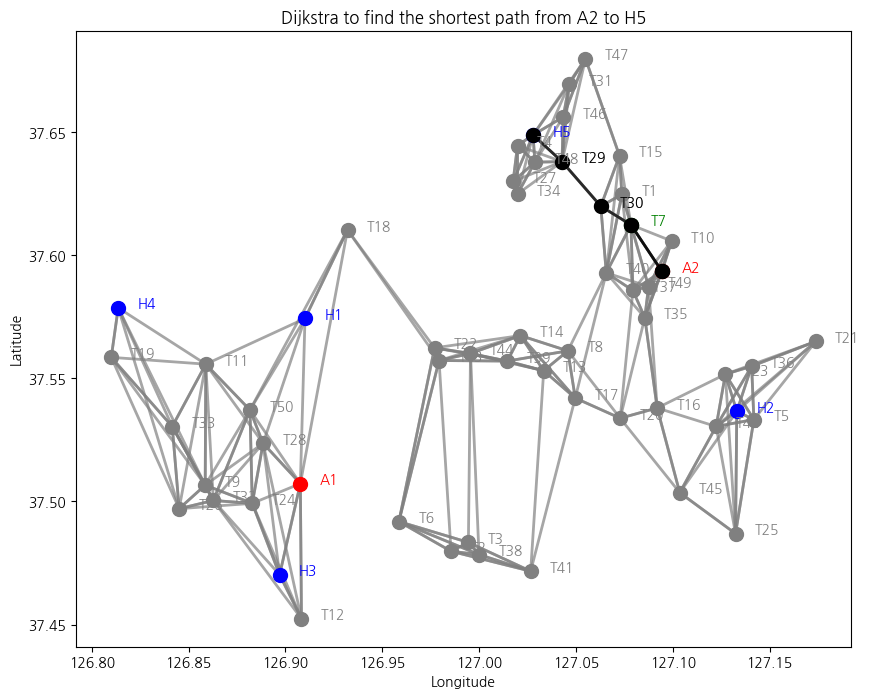

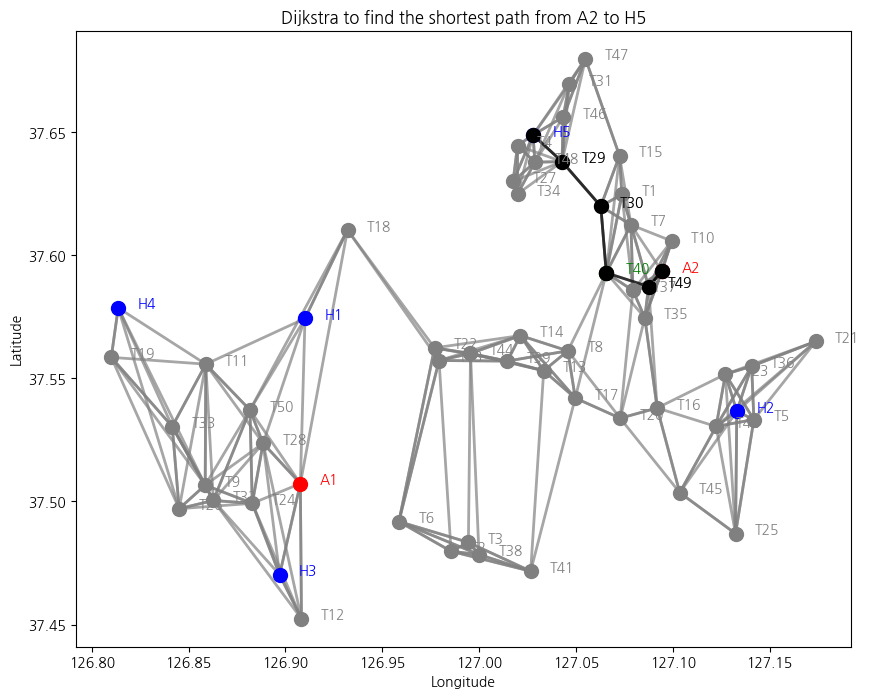

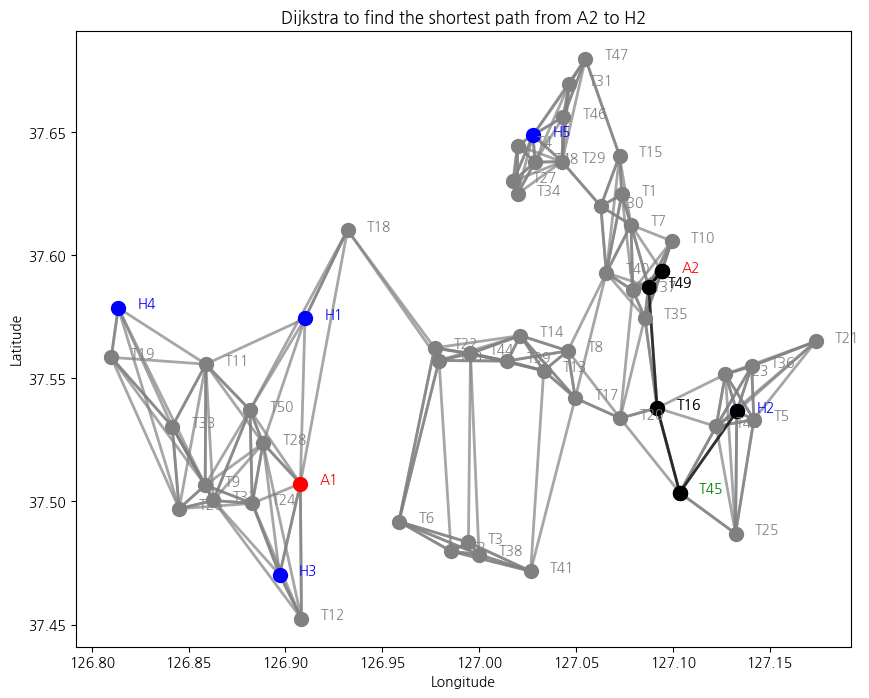

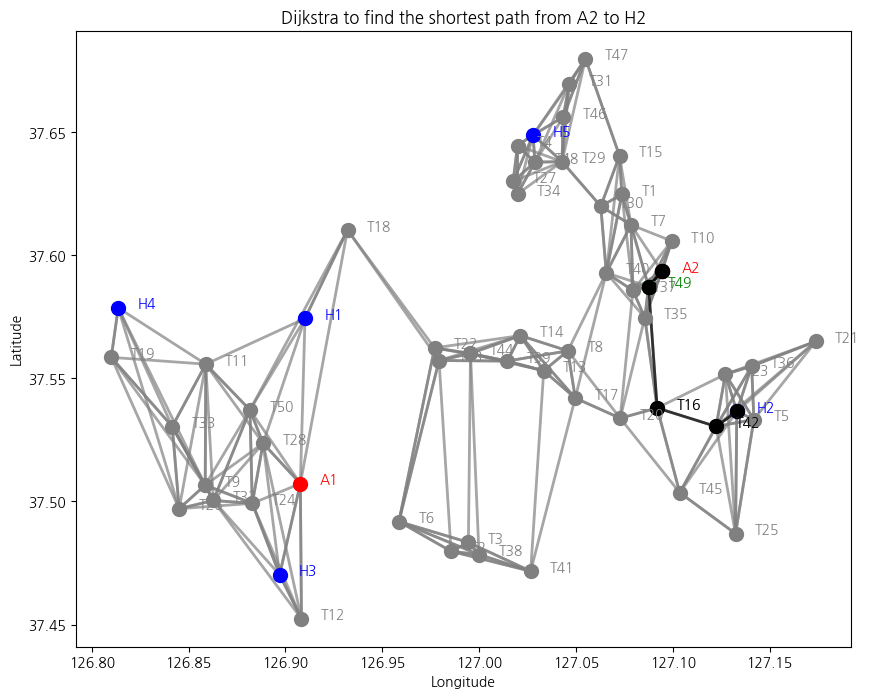

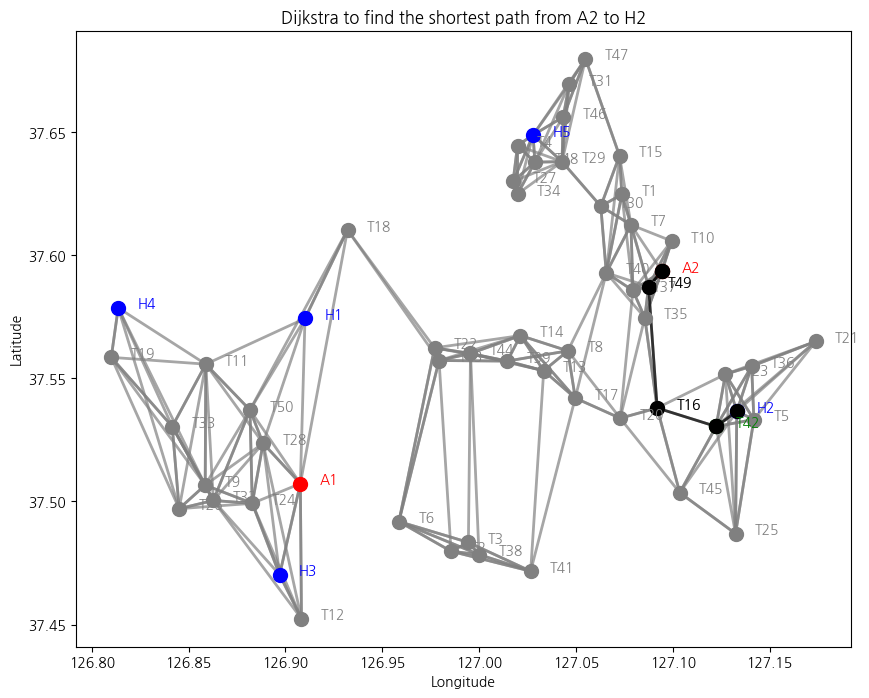

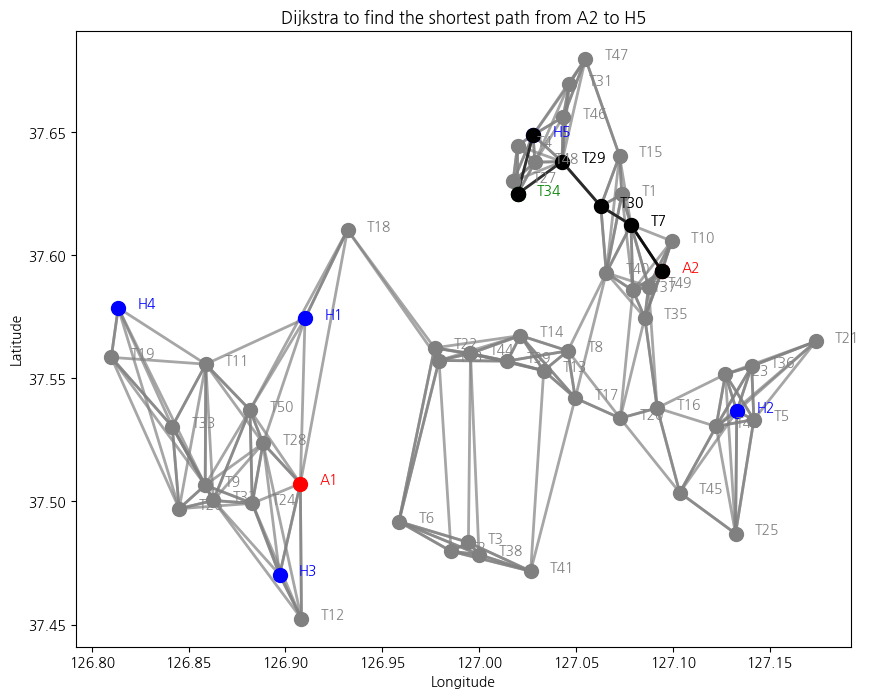

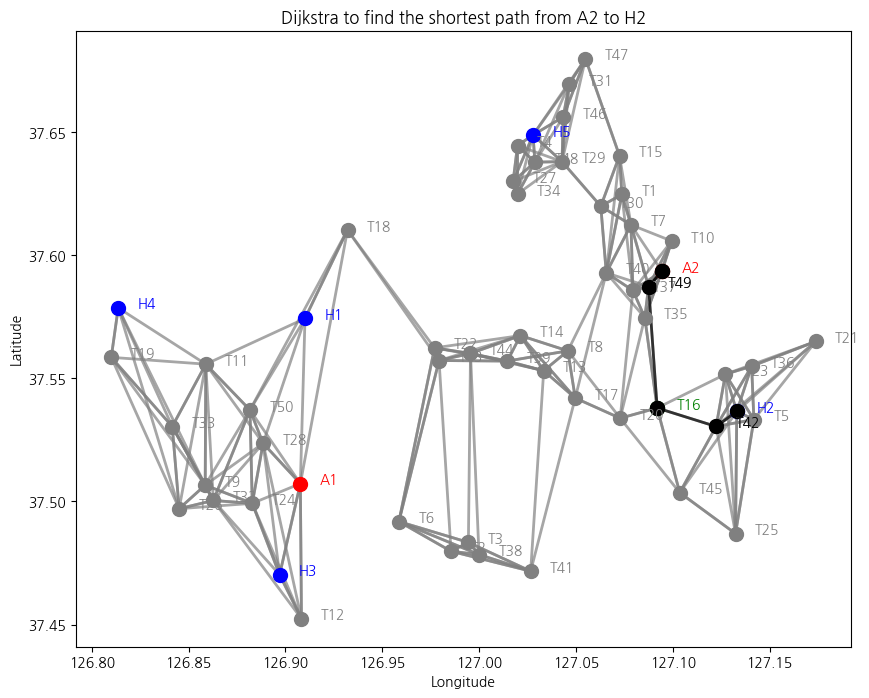

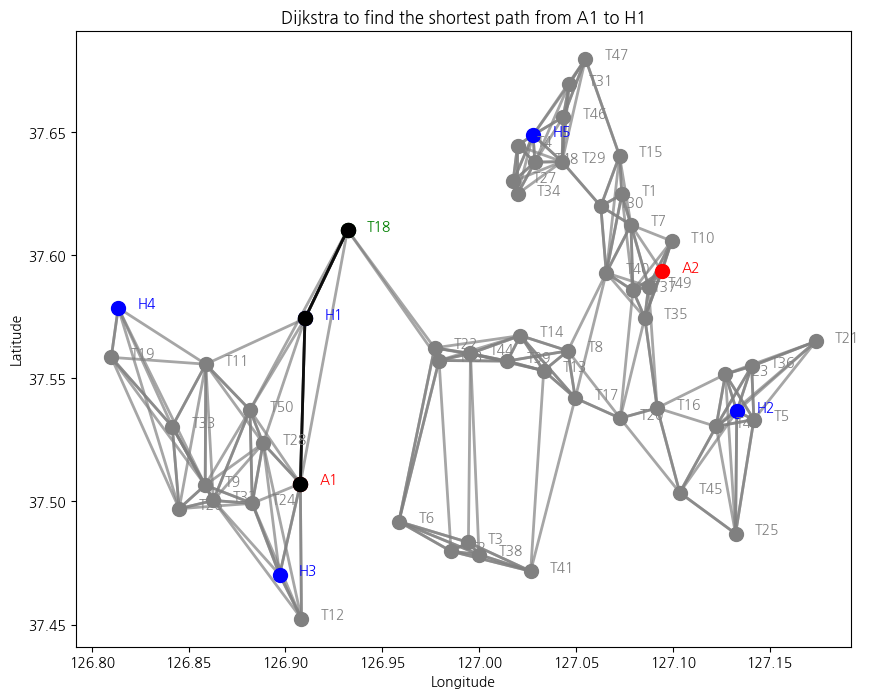

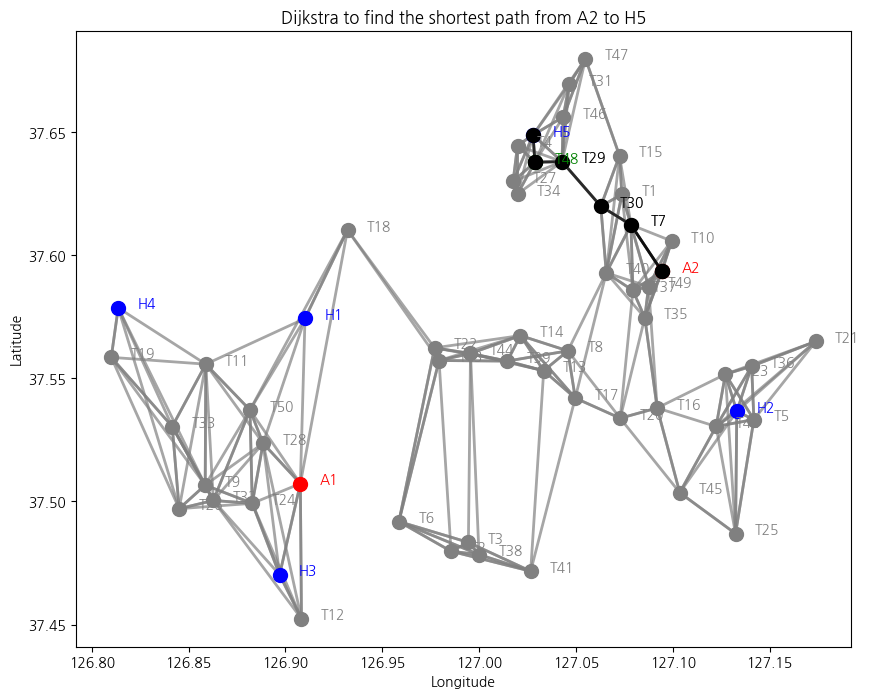

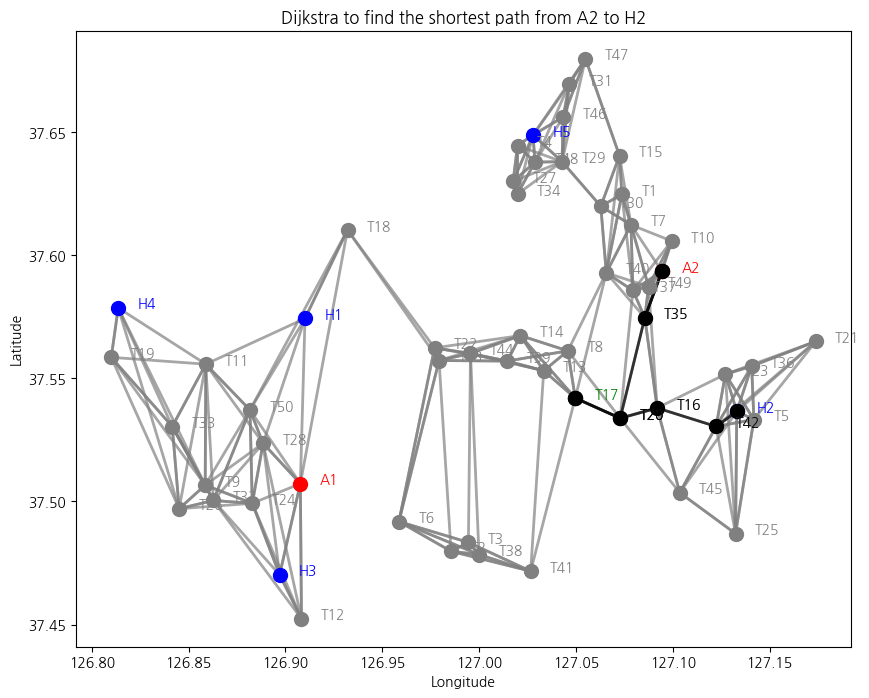

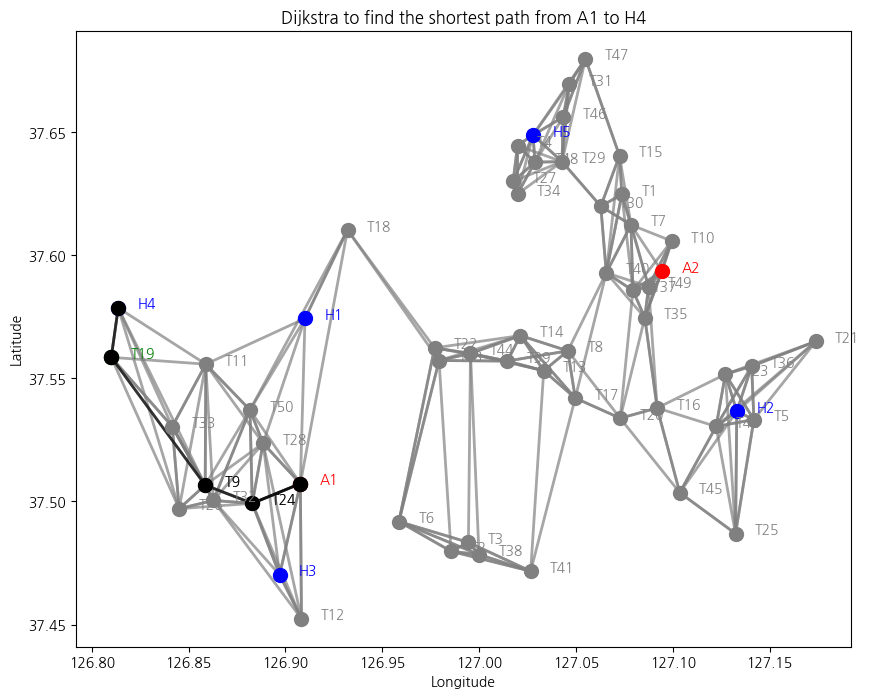

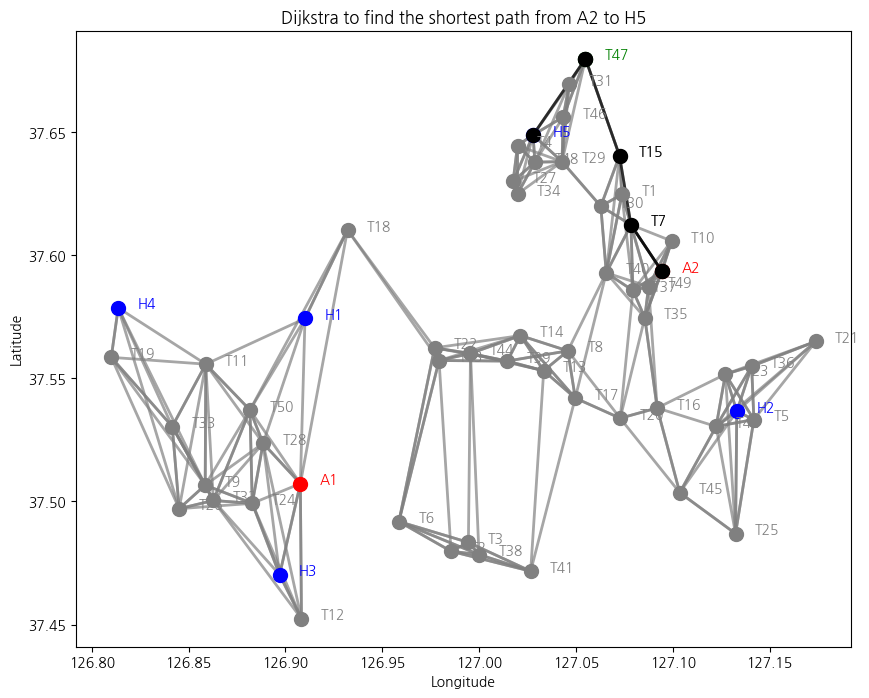

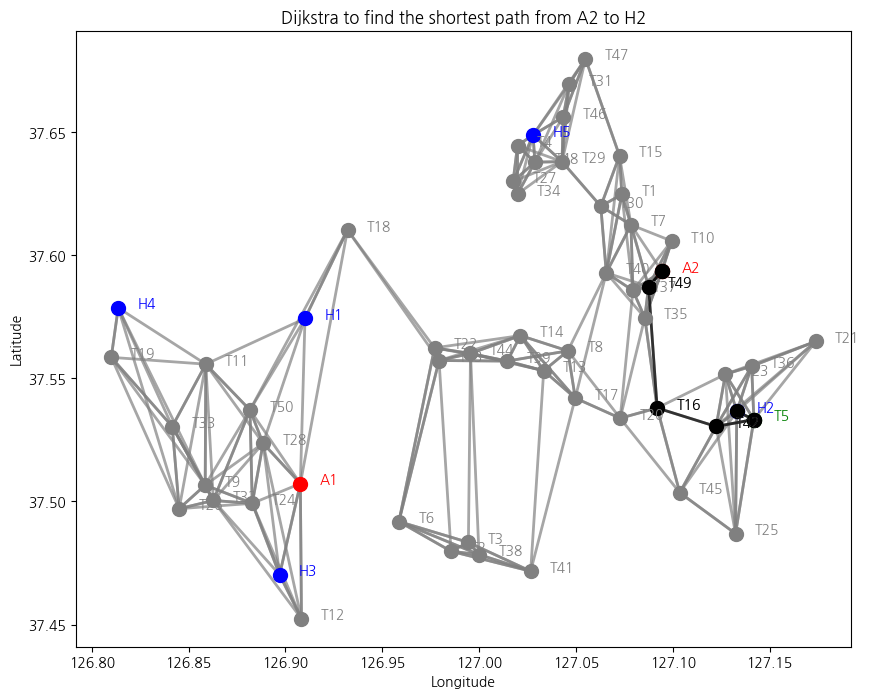

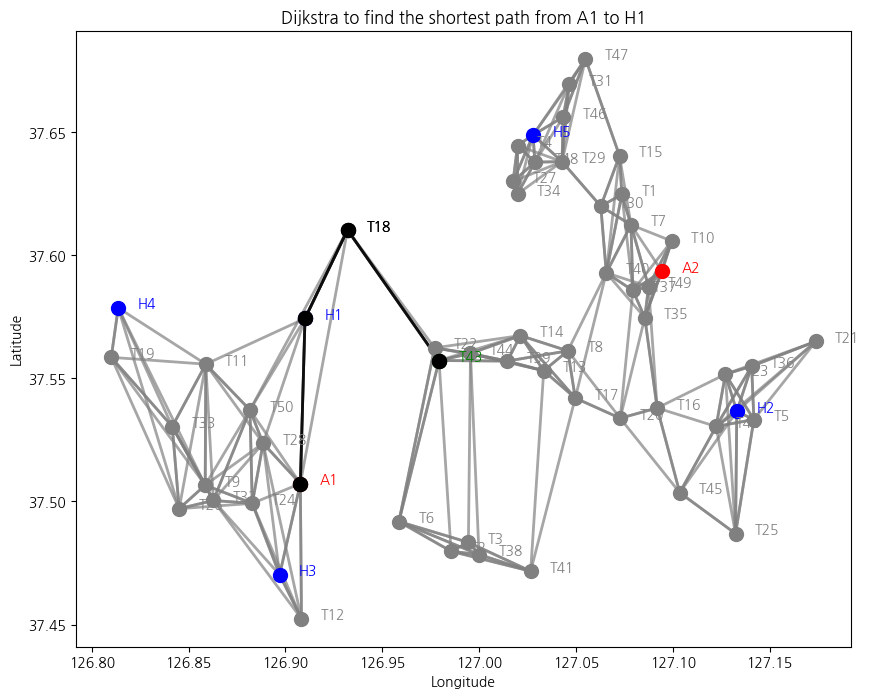

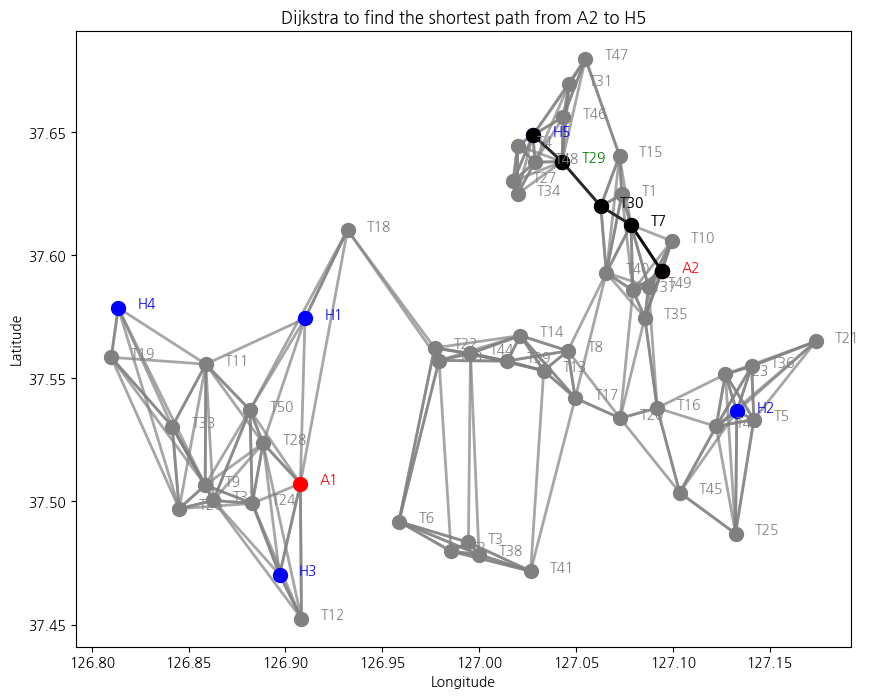

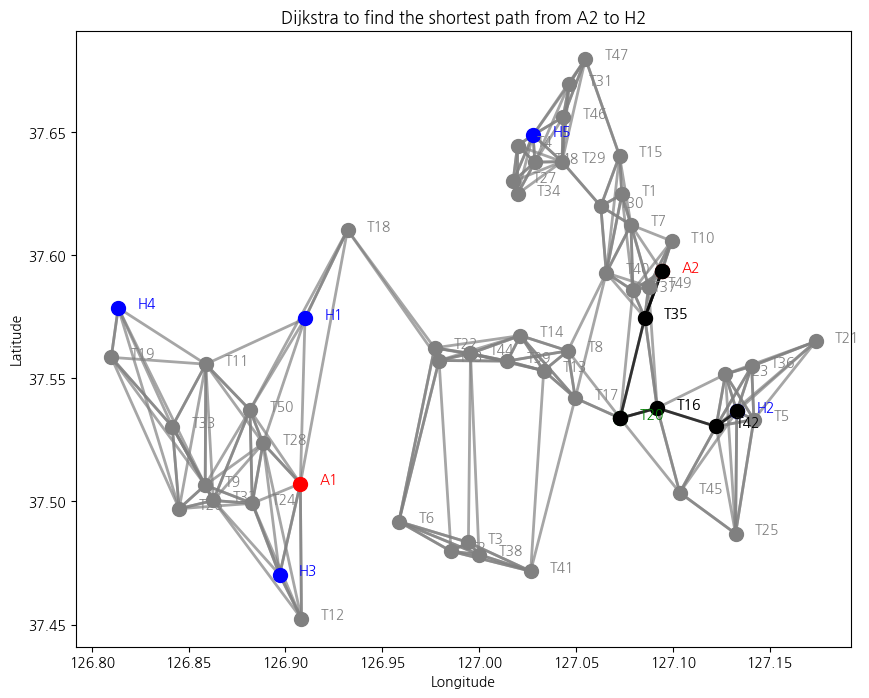

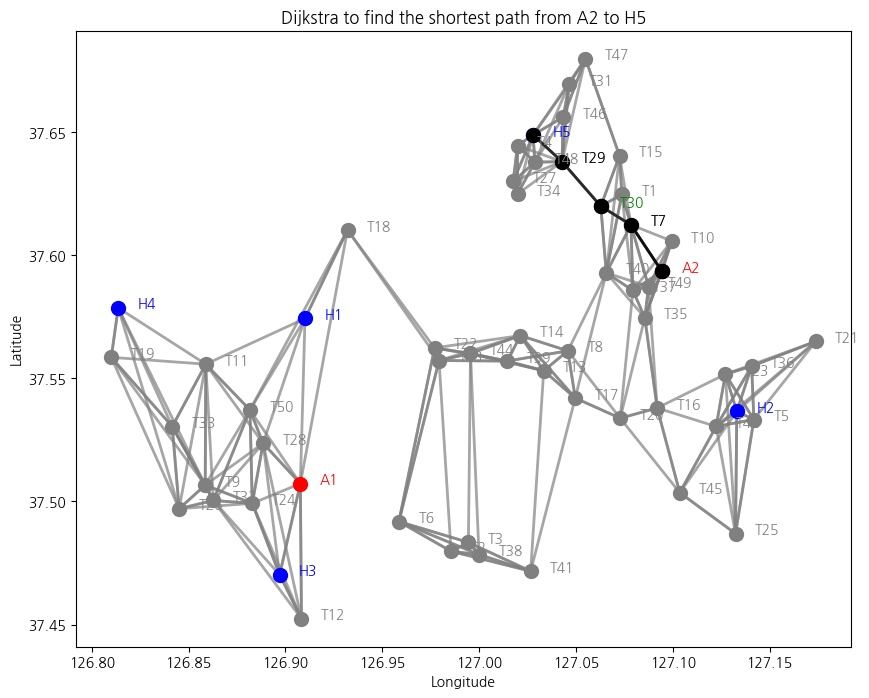

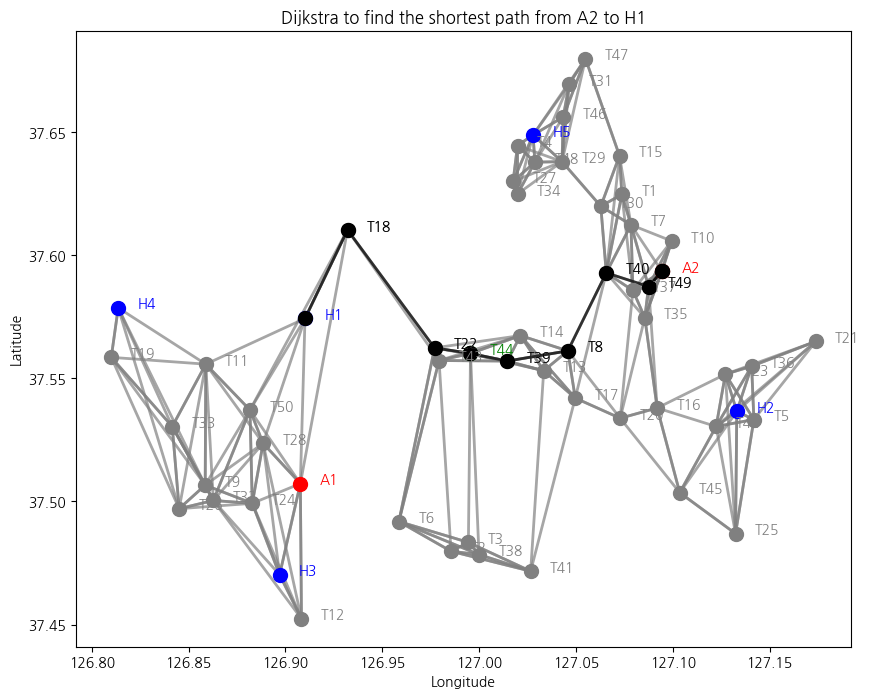

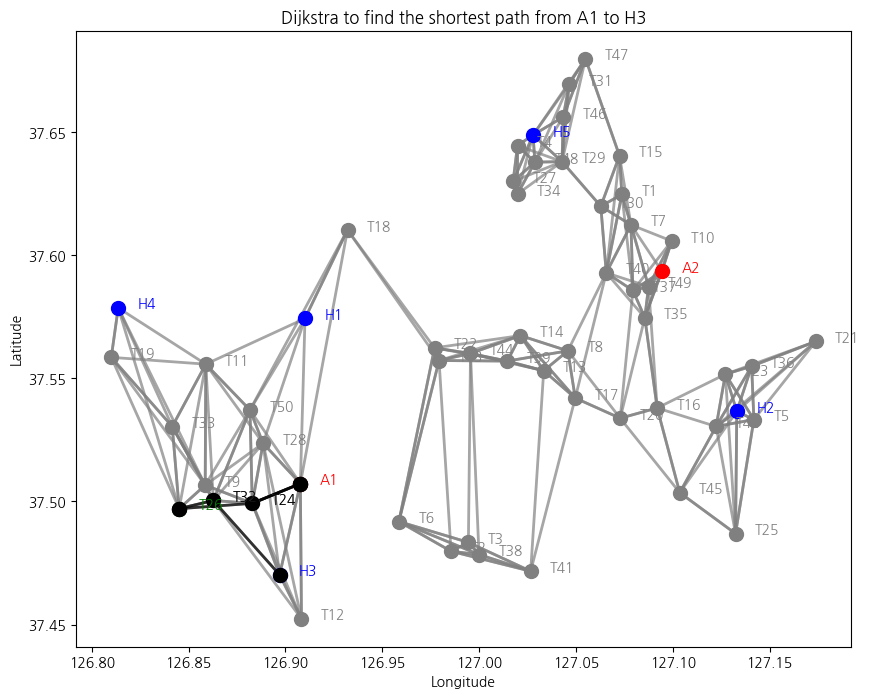

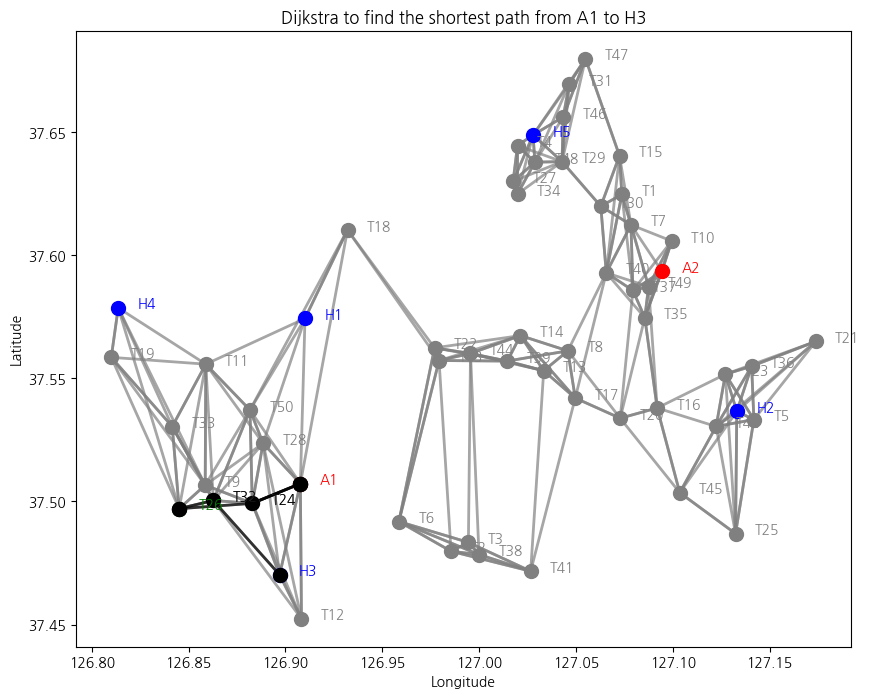

In [38]:
def animating(frame, coordinates, order, eventplace, ax, pointsize):
    """
    Function for individual animations.

    Args:
        frame (int): frame argument for FuncAnimation function
        coordinates (dict): dictionary with nodes as keys and coordinates as values
        order (list): list containing information on the shortest path
        eventplace (str): node where the emergency event takes place
        ax (axes): axes object of Matplotlib
        pointsize (int): size of the scatter plots
    Returns:
        None
    """
    # Get current node in frame and change color
    city = order[frame]
    ax.scatter(*coordinates[city], color="black", s=pointsize, zorder=4)
    if city not in ambulance+hospital+[eventplace]:
        ax.text(coordinates[city][0]+0.01, coordinates[city][1], city, fontsize=10, zorder=5, color="black")
    # Change color of the edge
    if frame+1 < len(order) and city != order[frame+1]:
        xi1, xi2 = coordinates[city]
        xj1, xj2 = coordinates[order[frame+1]]
        ax.plot([xi1, xj1], [xi2, xj2], color='black', alpha=0.7, lw=2, zorder=1)

def make_shortest_path_animation(coordinates, edges, order, eventplace, fig, ax, pointsize=100):
    """
    Function to plot the graph and animation for individual events.

    Args:
        coordinates (dict): dictionary with nodes as keys and coordinates as values
        edges (): 
        order (list): list containing information on the shortest path
        eventplace (str): node where the emergency event takes place
        fig (figure): Matplotlib figure object
        ax (axes): axes object of Matplotlib
        pointsize (int): size of the scatter plots (default: 100)
    Returns:
        None
    """
    # Plot the edges
    for w, i, j in edges:
        xi1, xi2 = coordinates[i]
        xj1, xj2 = coordinates[j]
        ax.plot([xi1, xj1], [xi2, xj2], color='grey', alpha=0.7, lw=2, zorder=1)

    # Plot the nodes
    for city, (lon, lat) in coordinates.items():
        # Use different colors for different types of nodes
        if city == eventplace:
            ax.scatter(lon, lat, color="green", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="green")
        elif city in hospital:
            ax.scatter(lon, lat, color="blue", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="blue")
        elif city in ambulance:
            ax.scatter(lon, lat, color="red", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="red")
        else:
            ax.scatter(lon, lat, color="grey", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="grey")
    # Animate
    anim = FuncAnimation(fig, partial(animating, coordinates, edges, order, eventplace, fig, ax, pointsize),
                                frames=range(len(order)), interval=500)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return anim

# Loop over all events
for e in range(events):
    # Get path information on each event
    g = graph_list[e]
    closest = g[2]
    # Plot the path and save as gif
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('Dijkstra to find the shortest path from {} to {}'.format(closest[0][0], closest[0][-1]))
    anim = make_shortest_path_animation(graph_dict, edges, closest[0], g[0], fig, ax)
    anim.save('animations/Dijkstra_animated_event{}.gif'.format(e+1), dpi=120, writer='imagemagick')

One long animation for all emergency events.

First, pool all node and edge information of all events together then animate one event after another in one plot.

In [54]:
def pool_events(graph_list):
    timeline = []
    # Loop over each event
    for source, sink, path, start_time in graph_list:
        current_time = start_time
        # The event taking place at current time
        timeline.append((None, current_time, source))
        # Loop over each node in the path
        for i, city in enumerate(path[0]):
            if i+1 < len(path[0]):
                end_city = path[0][i+1]     # Node connected to the current one
                # Skip if the two nodes are the same (event node)
                if i > 0 and city == path[0][i+1]:
                    continue
                timeline.append((city, current_time, end_city))
            else:
                # The last node in the path
                timeline.append((city, current_time, None))
                # Added so that the animation can reset before the next event
                timeline.append((None, current_time, None))
                break
            # Get exact travel time to the node
            travel_time = adj_graph[city][end_city]['TravelTime']
            traffic_time = adj_graph[city][end_city]['TrafficTime']
            if current_time.weekday() >= 5:
                current_traffic = traffic_factor['weekend'][current_time.hour] * traffic_time
            else:
                current_traffic = traffic_factor['weekday'][current_time.hour] * traffic_time
            current_time += datetime.timedelta(minutes=travel_time + current_traffic)
    #sorted_timeline = sorted(timeline, key=lambda x: x[1])
    return timeline

timeline = pool_events(graph_list)
print(timeline)

[(None, datetime.datetime(2023, 6, 10, 15, 0), 'T7'), ('A2', datetime.datetime(2023, 6, 10, 15, 0), 'T7'), ('T7', datetime.datetime(2023, 6, 10, 15, 3, 4, 80000), 'T30'), ('T30', datetime.datetime(2023, 6, 10, 15, 6, 8, 160000), 'T29'), ('T29', datetime.datetime(2023, 6, 10, 15, 10, 44, 100000), 'H5'), ('H5', datetime.datetime(2023, 6, 10, 15, 13, 48, 180000), None), (None, datetime.datetime(2023, 6, 10, 15, 13, 48, 180000), None), (None, datetime.datetime(2023, 6, 10, 15, 59), 'T40'), ('A2', datetime.datetime(2023, 6, 10, 15, 59), 'T49'), ('T49', datetime.datetime(2023, 6, 10, 16, 0, 32, 40000), 'T40'), ('T40', datetime.datetime(2023, 6, 10, 16, 5, 7, 980000), 'T30'), ('T30', datetime.datetime(2023, 6, 10, 16, 8, 12, 60000), 'T29'), ('T29', datetime.datetime(2023, 6, 10, 16, 12, 48), 'H5'), ('H5', datetime.datetime(2023, 6, 10, 16, 15, 52, 80000), None), (None, datetime.datetime(2023, 6, 10, 16, 15, 52, 80000), None), (None, datetime.datetime(2023, 6, 10, 16, 46), 'T45'), ('A2', datet

MovieWriter imagemagick unavailable; using Pillow instead.


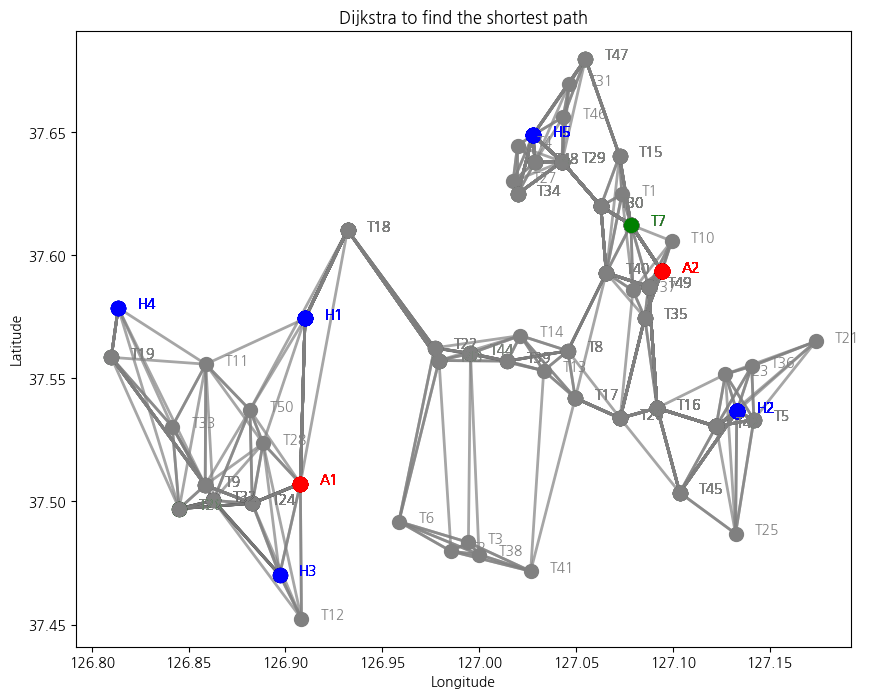

In [37]:
def animating(frame, coordinates, order, eventplace, ax, pointsize):
    """
    Function for animations.

    Args:
        frame (int): frame argument for FuncAnimation function
        coordinates (dict): dictionary with nodes as keys and coordinates as values
        order (list): list containing information on the shortest path
        eventplace (list): list of all nodes where the emergency events take place
        ax (axes): axes object of Matplotlib
        pointsize (int): size of the scatter plots
    Returns:
        None
    """
    # Get current node in frame
    city, time_city, end_city = order[frame]
    # If it is the event node, mark it in green
    if not city and end_city:
        ax.scatter(*coordinates[end_city], color="green", s=pointsize, zorder=2)
        ax.text(coordinates[end_city][0]+0.01, coordinates[end_city][1], end_city, fontsize=10, zorder=5, color="green")
    # Plot nodes
    elif city:
        ax.scatter(*coordinates[city], color="black", s=pointsize, zorder=2)
        if city not in ambulance+hospital+eventplace:
            ax.text(coordinates[city][0]+0.01, coordinates[city][1], city, fontsize=10, zorder=5, color="black")
        # If it is not the ending node (hospital), plot the edges as well
        if end_city:
            xi1, xi2 = coordinates[city]
            xj1, xj2 = coordinates[end_city]
            ax.plot([xi1, xj1], [xi2, xj2], color='black', alpha=0.7, lw=2, zorder=1)
    # Reset the graph for the next event
    else:
        # Loop over all frames until this one and reset the colors and graph if it has been changed before
        for i in range(frame):
            c, t, e = order[i]
            if c:
                lon, lat = coordinates[c]
                # Use different colors for different types of nodes
                if c in hospital:
                    ax.scatter(lon, lat, color="blue", s=pointsize, zorder=2)
                    ax.text(lon+0.01, lat, c, fontsize=10, zorder=5, color="blue")
                elif c in ambulance:
                    ax.scatter(lon, lat, color="red", s=pointsize, zorder=2)
                    ax.text(lon+0.01, lat, c, fontsize=10, zorder=5, color="red")
                else:
                    ax.scatter(lon, lat, color="grey", s=pointsize, zorder=2)
                    ax.text(lon+0.01, lat, c, fontsize=10, zorder=5, color="grey")
                if e:
                    xi1, xi2 = coordinates[c]
                    xj1, xj2 = coordinates[e]
                    ax.plot([xi1, xj1], [xi2, xj2], color='grey', alpha=0.7, lw=2, zorder=1)

def make_shortest_path_animation(coordinates, edges, order, eventplace, fig, ax, pointsize=100):
    """
    Function to plot the graph and animation for all events.

    Args:
        coordinates (dict): dictionary with nodes as keys and coordinates as values
        edges (list): edge information
        order (list): list containing information on the shortest path
        eventplace (list): list of all nodes where the emergency events take place
        fig (figure): Matplotlib figure object
        ax (axes): axes object of Matplotlib
        pointsize (int): size of the scatter plots (default: 100)
    Returns:
        None
    """
    # Plot edges
    for w, i, j in edges:
        xi1, xi2 = coordinates[i]
        xj1, xj2 = coordinates[j]
        ax.plot([xi1, xj1], [xi2, xj2], color='grey', alpha=0.7, lw=2, zorder=1)

    # Plot nodes
    for city, (lon, lat) in coordinates.items():
        # Use different colors for different types of nodes
        if city in hospital:
            ax.scatter(lon, lat, color="blue", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="blue")
        elif city in ambulance:
            ax.scatter(lon, lat, color="red", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="red")
        else:
            ax.scatter(lon, lat, color="grey", s=pointsize, zorder=2)
            ax.text(lon+0.01, lat, city, fontsize=10, zorder=5, color="grey")
    
    # Plot animations
    anim = FuncAnimation(fig, partial(animating, coordinates, edges, order, eventplace, fig, ax, pointsize),
                                frames=range(len(order)), interval=500)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return anim

eventplaces = [i[0] for i in graph_list]
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Dijkstra to find the shortest path')
anim = make_shortest_path_animation(graph_dict, edges, timeline, eventplaces, fig, ax)
anim.save('animations/Dijkstra_animated_full.gif', dpi=120, writer='imagemagick')

### Resultant animation

<center><img src="animations/Dijkstra_animated_full.gif" alt="Drawing" class="" width="1500px"></center>

## A\* algorithm for the shortest path

In [14]:
def heuristic_distance(a, b, coordinates,current_time, traffic_factor):
    x1, y1, x2, y2 = coordinates[a][1], coordinates[a][0], coordinates[b][1], coordinates[b][0]
    dist = haversine.distance((x1,y1),(x2,y2))
    travel_time = math.ceil(dist/70*60)  # In minutes
    traffic_time =  round(travel_time/0.36,2)-travel_time
    if current_time.weekday() >= 5:
        current_traffic = traffic_factor['weekend'][current_time.hour] * traffic_time
    else:
        current_traffic = traffic_factor['weekday'][current_time.hour] * traffic_time
    new_time = travel_time + current_traffic
    return new_time
    


def reconstruct_path(previous, source, sink):
    if sink not in previous:
        return []
    v = sink
    path = [v]
    while v != source:
        v = previous[v]
        path = [v] + path
    return path


def astar_search(graph, source, sink, coordinates, start_time, traffic_factor):
    distance = {v: inf for v in graph.keys()}
    distance[source] = 0
    previous = {}
    current_time = start_time
    vertices_to_check = [(heuristic_distance(source, sink, coordinates,current_time, traffic_factor), source, current_time)]

    while vertices_to_check:
        heurisitc_dist, u, current_time = heapq.heappop(vertices_to_check)
        if u == sink:
            break

        for neighbor, neighbor_dist in graph[u].items():
            travel_time = neighbor_dist['TravelTime']
            traffic_time = neighbor_dist['TrafficTime']
            if current_time.weekday() >= 5:
                current_traffic = traffic_factor['weekend'][current_time.hour] * traffic_time
            else:
                current_traffic = traffic_factor['weekday'][current_time.hour] * traffic_time
            new_time = travel_time + current_traffic
            new_dist = distance[u] + new_time

            if new_dist < distance[neighbor]:
                distance[neighbor] = new_dist
                previous[neighbor] = u
                add_time = current_time + datetime.timedelta(minutes=new_time)
                f_value = new_dist + heuristic_distance(neighbor, sink, coordinates,current_time, traffic_factor)
                heapq.heappush(vertices_to_check, (f_value, neighbor, add_time))

    if not previous:
        return None, inf
    path = reconstruct_path(previous, source, sink)
    return path, distance[sink], current_time - start_time

In [15]:
def responder_to_house(ambulance, adj_graph, source, day, traffic_factor):
    am_to_town = ['', datetime.timedelta(seconds=86400), 0]
    for start in ambulance:
        distance, previous, time_difference = astar_search(adj_graph, start, source, graph_dict, day, traffic_factor)
        #print(distance, vertices, previous)
        #print(time_difference)
        if am_to_town[1] > time_difference:
            am_to_town = [distance, time_difference, len(distance)]
        elif am_to_town[1] == time_difference:
            if am_to_town[2] > len(distance):
                am_to_town = [distance, time_difference, len(distance)]
    starting_ambulance = am_to_town[0][0]
    print('\tchosen emergency responder: {}'.format(starting_ambulance))
    print('\tshortest path to household: {}'.format(am_to_town[0]))
    print('\ttime needed to household: {} minutes and {} seconds'.format(am_to_town[1].total_seconds()//60, am_to_town[1].total_seconds()%60))
    return am_to_town

    
def house_to_er(hospital, adj_graph, source, day, traffic_factor):
    town_to_hos = ['', datetime.timedelta(seconds=86400), 0]
    for sink in hospital:
        distance, previous, time_difference = astar_search(adj_graph, source, sink, graph_dict, day, traffic_factor)
        #print(distance, vertices, previous)
        #print(time_difference)
        if town_to_hos[1] > time_difference:
            town_to_hos = [distance, time_difference, len(distance)]
        elif town_to_hos[1] == time_difference:
            if town_to_hos[2] > len(distance):
                town_to_hos = [distance, time_difference, len(distance)]
    ending_hospital = town_to_hos[0][-1]
    print('\tchosen hospital: {}'.format(ending_hospital))
    print('\tshortest path to hospital: {}'.format(town_to_hos[0]))
    print('\ttime needed to hospital: {} minutes and {} seconds'.format(town_to_hos[1].total_seconds()//60, town_to_hos[1].total_seconds()%60))
    return town_to_hos

In [16]:
events = 20
graph_list = []
random.seed(5)
day_list = sorted(random.sample(range(0,1440),events-1))
random.seed(14)
start_day = datetime.datetime(2023,6,10,15,00)
day = datetime.datetime(2023,6,10,15,00)
for e in range(events):
    source = random.choice(towns)
    start_time = day
    print('Event {}: emergency at {} on {}'.format(e+1, source, day))
    am_to_town = responder_to_house(ambulance, adj_graph, source, day, traffic_factor)
    day += am_to_town[1]
    town_to_hos = house_to_er(hospital, adj_graph, source, day, traffic_factor)
    day += town_to_hos[1]
    final_sink = town_to_hos[0][-1]
    closest = [i+j for i,j in zip(am_to_town, town_to_hos)]
    graph_list.append([source, final_sink, closest, start_time])
    print('\tshortest path: {}'.format(closest[0]))
    print('\ttime needed for the shortest path: {} minutes and {} seconds'.format(closest[1].total_seconds()//60, closest[1].total_seconds()%60))
    print('End of event {}: {}'.format(e+1, day))
    if e < events-1:
        day = datetime.timedelta(minutes=day_list[e]) + start_day

Event 1: emergency at 중랑구 묵1동 on 2023-06-10 15:00:00
	chosen emergency responder: 중랑구 망우3동
	shortest path to household: ['중랑구 망우3동', '중랑구 묵1동']
	time needed to household: 3.0 minutes and 4.0800000000000125 seconds
	chosen hospital: 중랑구 묵1동
	shortest path to hospital: ['중랑구 묵1동', '노원구 하계1동', '노원구 상계1동', '도봉구 창5동', '도봉구 쌍문3동']
	time needed to hospital: 13.0 minutes and 48.17999999999995 seconds
	shortest path: ['중랑구 망우3동', '중랑구 묵1동', '중랑구 묵1동', '노원구 하계1동', '노원구 상계1동', '도봉구 창5동', '도봉구 쌍문3동']
	time needed for the shortest path: 16.0 minutes and 52.25999999999999 seconds
End of event 1: 2023-06-10 15:16:52.260000
Event 2: emergency at 동대문구 휘경1동 on 2023-06-10 15:59:00
	chosen emergency responder: 중랑구 망우3동
	shortest path to household: ['중랑구 망우3동', '중랑구 면목5동', '동대문구 휘경1동']
	time needed to household: 6.0 minutes and 8.160000000000025 seconds
	chosen hospital: 동대문구 휘경1동
	shortest path to hospital: ['동대문구 휘경1동', '노원구 하계1동', '노원구 상계1동', '도봉구 도봉2동', '도봉구 창5동', '도봉구 쌍문3동']
	time needed to hospital: 

# References

1. Pappinen, J., & Nordquist, H. (2022). Driving Speeds in Urgent and Non-Urgent Ambulance Missions during Normal and Reduced Winter Speed Limit Periods-A Descriptive Study. Nursing reports (Pavia, Italy), 12(1), 50–58. https://doi.org/10.3390/nursrep12010006
2. Seoul Metropolitan City (2022). 2022 Report of Traffic Speeds in Seoul Metropolitan City. 51-6110000-002492-10 (https://topis.seoul.go.kr/refRoom/openRefRoom_1.do)